In [1]:
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shutil
import tensorflow as tf

from pathlib import Path
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

2024-02-23 18:22:30.326254: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 18:22:30.326356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 18:22:30.446802: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# ELEC0135 Assignment

## Introduction

Based on the competition here: https://www.kaggle.com/competitions/cassava-leaf-disease-classification

## Source Data

As this is an exploratory Kaggle notebook, I've just loaded in the hosted `cassava-leaf-diesease-classification` dataset in here.  The final script will need some data loading logic, so that it can be submitted for testing/marking purposes.

In [2]:
SOURCE_DATA = Path("/kaggle/input/cassava-leaf-disease-classification/")

WORKING_DATA = Path("/kaggle/working/data/elec0135-assignment-cld/")
WORKING_DATA.mkdir(parents=True, exist_ok=True)

# Parameters
IMAGE_SIZE = 120
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.25
EPOCHS = 50

## EDA

### What are we looking at?

In [3]:
with open(SOURCE_DATA / "label_num_to_disease_map.json", "r") as label_file:
    print(json.dumps(json.load(label_file),indent=2))

{
  "0": "Cassava Bacterial Blight (CBB)",
  "1": "Cassava Brown Streak Disease (CBSD)",
  "2": "Cassava Green Mottle (CGM)",
  "3": "Cassava Mosaic Disease (CMD)",
  "4": "Healthy"
}


### Class Balance

In [4]:
df_train = pd.read_csv(SOURCE_DATA / "train.csv")
df_train.groupby(['label']).count()

,image_id
label,
0,1087
1,2189
2,2386
3,13158
4,2577


There's a large class imbalance here for `0` (CBB), which will need taking into account during the training.  Initial thoughts are that this will be especially true if I end up using a binary-classification gate in a `Mixture of Experts` model.

### Some Sample Images

In [5]:
def get_image_path(image_id: str) -> Path:
    return SOURCE_DATA / "train_images" / image_id

In [6]:
im = Image.open(get_image_path(df_train.loc[0, "image_id"]))
print(im.size)

(800, 600)


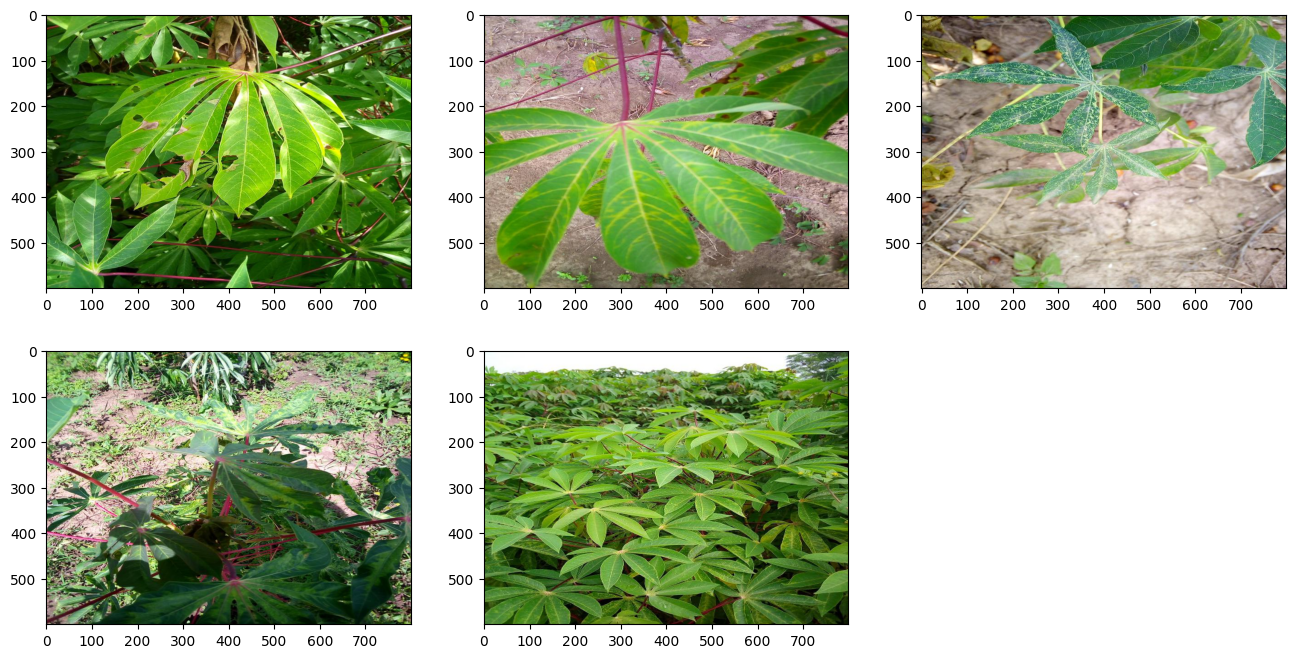

In [7]:
df_single_sample = df_train.groupby('label').apply(lambda x: x.sample(1), include_groups = False).reset_index()

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
plt.axis('off')

for index, row in df_single_sample.iterrows():
    lab = row["label"]
    image_id = row["image_id"]
    a = plt.imread(get_image_path(image_id))
    axs[int(index/3), index%3].imshow(a)

There's high variability in the images - some closer shots, some further away etc.

## Data Processing

With only ~1000 instances of label/class `0`, my first thought is that some data augmentation is going to be required here.  I'm going to hold off with that first and see how a basic VGG-style network, such as that explored in the labs, fares.

Ideas:

* Data Augmentation
* For the assignment, shrink the images to make the data aspect more manageable
* Train on full (unbalanced) dataset
* Train on balanced (smaller) dataset

In [8]:
def create_equal_split_dataset(df_map: pd.DataFrame) -> Path:
    es_path = WORKING_DATA / "equal_split"
    es_path.mkdir(parents=True, exist_ok=True)
    
    for lab in df_map.label.unique():
        (es_path / str(lab)).mkdir(exist_ok=True)
        
    source_path = SOURCE_DATA / "train_images"
    
    # take n first items from each class
    df_map['counter'] = 1
    df_map['class_count'] = df_map[['label', 'counter']].groupby(['label']).cumsum()
    
    for index, row in df_map.iterrows():
        lab = row["label"]
        image_id = row["image_id"]
        img = source_path / image_id
        dest = es_path / str(lab) / image_id

        class_count = row["class_count"]
        if class_count > 1087:
            continue
        shutil.copyfile(img, dest)
        
    return es_path


def get_equal_split_dataset(path: Path):
    # Load dataset
    # categorical here means that the labels are one-hot encoded
    ds_train_, ds_valid_ = image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[IMAGE_SIZE, IMAGE_SIZE],
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_split=VALIDATION_SPLIT,
        subset="both",
        seed=31415,
    )   

    # Data Pipeline
    def convert_to_float(image, label):
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        image = image / 255.0
        return image, label

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds_train = (
        ds_train_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    ds_valid = (
        ds_valid_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    
    return ds_train, ds_valid


def plot_experiment_results(df_history: pd.DataFrame, exp_id: str) -> None:
    df = df_history[df_history.exp_id == exp_id]
    df[['loss', 'val_loss']].plot()
    df[['accuracy', 'val_accuracy']].plot();

In [9]:
# need to add some optimisation here to avoid re-create files if already exist
dataset_path = create_equal_split_dataset(df_train)

In [10]:
ds_train, ds_valid = get_equal_split_dataset(dataset_path)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.


### Model

In [11]:
# df_experiment = pd.DataFrame(columns=["exp_id", "desc", "batch_size", "img_width", "img_height", "model"])
# df_history = pd.DataFrame(columns=["loss", "accuracy", "val_loss", "val_accuracy"])

In [12]:
# quick convnet, similar to that used here: https://www.kaggle.com/code/ryanholbrook/custom-convnets
def create_simple_model() -> Model:
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Fourth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [13]:
# quick convnet, similar to that used here: https://www.kaggle.com/code/ryanholbrook/custom-convnets
def create_simple_model_bn() -> Model:
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Fourth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Classifier Head
        # layers.BatchNormalization(renorm=True),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [14]:
def run_experiment(exp_id: str, sub_exp_id: int, model_fn: str, ds_train_, ds_valid_):
    
    #data = {"exp_id":"1", "desc":"something", "batch_size":BATCH_SIZE, "img_width":0, "img_height":0, "model": model_str}
    #df_experiment = pd.concat([pd.DataFrame([data]), df_experiment])
    
    model = model_fn()
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=10,
        restore_best_weights=True,
    )

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[early_stopping]
    )
    
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["exp_id"] = exp_id
    df_hist["sub_exp_id"] = sub_exp_id
    df_hist["epoch"] = df_hist.index
   
    return model, df_hist


def add_results(df_all_results, df_new_results):
    if df_all_results.empty:
        return df_new_results
    else:
        return pd.concat([df_all_results, df_new_results])

In [15]:
df_results = pd.DataFrame

In [16]:
for i in range(0, 1):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("1", i, create_simple_model, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Epoch 1/50


I0000 00:00:1708712624.807763      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 [==============================] - 19s 142ms/step - loss: 1.6096 - accuracy: 0.1977 - val_loss: 1.6089 - val_accuracy: 0.2040
Epoch 2/50
64/64 [==============================] - 4s 59ms/step - loss: 1.6085 - accuracy: 0.2107 - val_loss: 1.6074 - val_accuracy: 0.1900
Epoch 3/50
64/64 [==============================] - 4s 59ms/step - loss: 1.6048 - accuracy: 0.2232 - val_loss: 1.5950 - val_accuracy: 0.2563
Epoch 4/50
64/64 [==============================] - 4s 58ms/step - loss: 1.5720 - accuracy: 0.2718 - val_loss: 1.5731 - val_accuracy: 0.2577
Epoch 5/50
64/64 [==============================] - 4s 58ms/step - loss: 1.5344 - accuracy: 0.2845 - val_loss: 1.5119 - val_accuracy: 0.3122
Epoch 6/50
64/64 [==============================] - 4s 58ms/step - loss: 1.4963 - accuracy: 0.3029 - val_loss: 1.5679 - val_accuracy: 0.2673
Epoch 7/50
64/64 [==============================] - 4s 59ms/step - loss: 1.4997 - accuracy: 0.3100 - val_loss: 1.4954 - val_accuracy: 0.3270
Epoch 8/50
64/64 [====

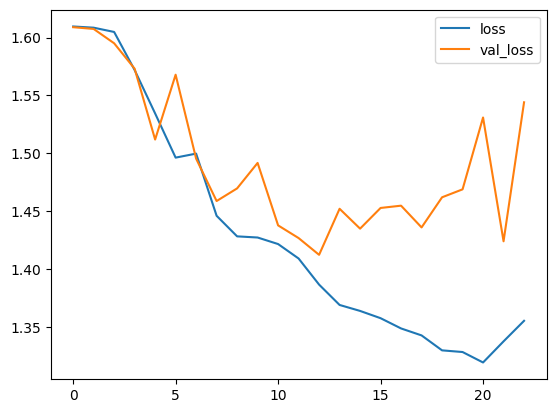

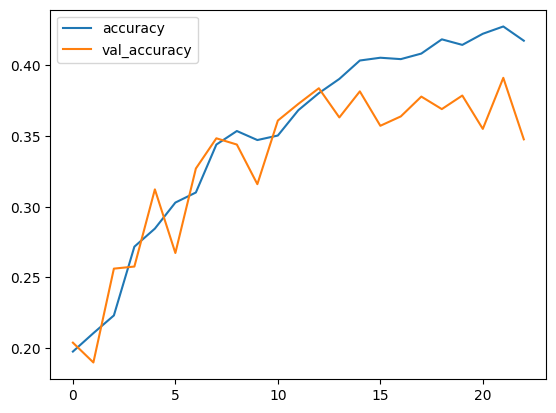

In [17]:
plot_experiment_results(df_results, "1")

In [18]:
for i in range(0, 1):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("2", i, create_simple_model_bn, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Epoch 1/50
64/64 [==============================] - 11s 101ms/step - loss: 1.6095 - accuracy: 0.2001 - val_loss: 1.6094 - val_accuracy: 0.1885
Epoch 2/50
64/64 [==============================] - 4s 58ms/step - loss: 1.6096 - accuracy: 0.1943 - val_loss: 1.6091 - val_accuracy: 0.1885
Epoch 3/50
64/64 [==============================] - 4s 58ms/step - loss: 1.6075 - accuracy: 0.2254 - val_loss: 1.6072 - val_accuracy: 0.1885
Epoch 4/50
64/64 [==============================] - 4s 58ms/step - loss: 1.5994 - accuracy: 0.2306 - val_loss: 1.5860 - val_accuracy: 0.2482
Epoch 5/50
64/64 [==============================] - 4s 58ms/step - loss: 1.5994 - accuracy: 0.2190 - val_loss: 1.5712 - val_accuracy: 0.1988
Epoch 6/50
64/64 [==============================] - 4s 57ms/step - loss: 1.5501 - accuracy: 0.2720 - val_loss: 1.5260 - val_accuracy: 0.3203
Epoch 7/50
64/64 [=============================

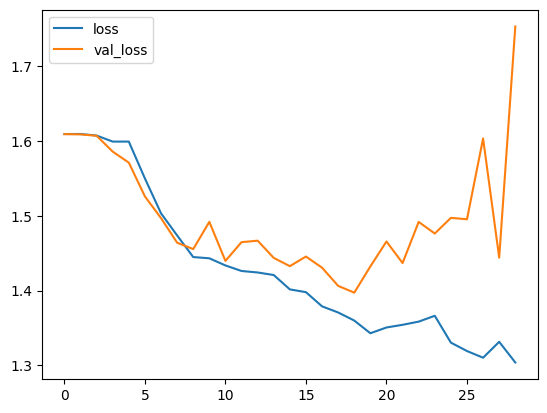

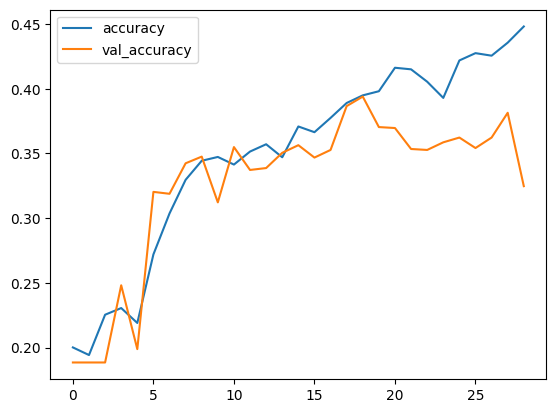

In [19]:
plot_experiment_results(df_results, "2")

In [20]:
for i in range(0, 5):
    print(f"Running Subexperiment {i}")
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("3", i, create_simple_model_bn, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Running Subexperiment 0
Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Epoch 1/50
64/64 [==============================] - 12s 116ms/step - loss: 1.6095 - accuracy: 0.2092 - val_loss: 1.6091 - val_accuracy: 0.2047
Epoch 2/50
64/64 [==============================] - 4s 58ms/step - loss: 1.6077 - accuracy: 0.2171 - val_loss: 1.6068 - val_accuracy: 0.2290
Epoch 3/50
64/64 [==============================] - 4s 58ms/step - loss: 1.6041 - accuracy: 0.2291 - val_loss: 1.5928 - val_accuracy: 0.2423
Epoch 4/50
64/64 [==============================] - 4s 58ms/step - loss: 1.5869 - accuracy: 0.2468 - val_loss: 1.5996 - val_accuracy: 0.2312
Epoch 5/50
64/64 [==============================] - 4s 58ms/step - loss: 1.5543 - accuracy: 0.2615 - val_loss: 1.5573 - val_accuracy: 0.2820
Epoch 6/50
64/64 [==============================] - 4s 58ms/step - loss: 1.5289 - accuracy: 0.2914 - val_loss: 1.5292 - val_accuracy: 0.2968
Epoch 7/50
64/64 [=====

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

<Axes: xlabel='epoch', ylabel='val_loss'>

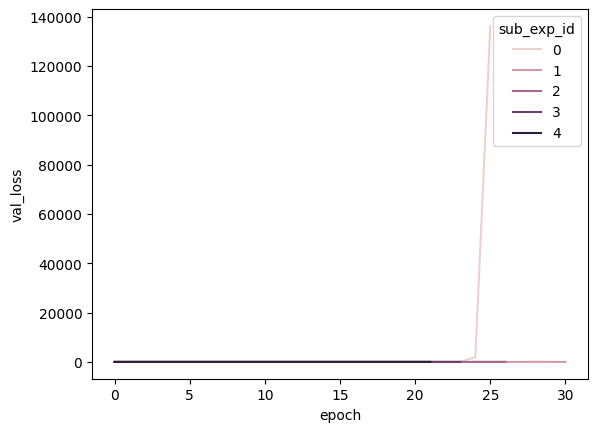

In [21]:
sns.lineplot(data=df_results[df_results.exp_id=="3"], x="epoch", y="val_loss", hue="sub_exp_id")

Across 5 runs of the same model, this looks incredibly noisy. Before trying to refine the model more, I thought it might be worth exploring some data augmentation.

Useful links found so far:
    
https://keras.io/api/data_loading/image/

https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

https://keras.io/api/applications/vgg/

https://keras.io/api/applications/mobilenet/#mobilenetv2-function

https://keras.io/api/models/model_training_apis/

https://stackoverflow.com/questions/66715975/class-weights-in-cnn

https://www.kaggle.com/code/ryanholbrook/overfitting-and-underfitting